In [1]:
import torch
import plotly
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import json
import pandas as pd
import plotly.express as px

In [2]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = nn.functional.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = nn.functional.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = torch.tanh(self.fc4(x))

        return out

In [4]:
z_size = 100
g_output_size = 784
g_hidden_size = 32

model_path = "model/2021-05-26T12:03:27/checkpoint.pt"

G = Generator(z_size, g_hidden_size, g_output_size).to(device=device)
checkpoint = torch.load(model_path)
G.load_state_dict(checkpoint["gen_state_dict"]);

## Generate some random digits

In [5]:
def view_samples(epoch, samples, save=False):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    if save:
        now = dt.now()
        stamp = now.strftime("%Y-%m-%dT%H:%M:%S")
        fig.savefig(f"images/{stamp}.pdf")

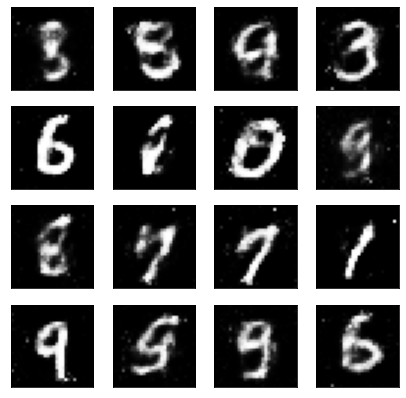

In [6]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

## Plot loss

In [7]:
losses_path = "model/2021-05-26T14:25:33/losses.json"
with open(losses_path, "r") as f:
    losses = json.load(f)

In [8]:
losses_df = pd.DataFrame(losses)
losses_df.rename(columns={0: "discriminator", 1: "generator"}, inplace=True)

In [9]:
plotly.io.orca.config.executable = '/home/jack/.miniconda/envs/toy-gan/bin/orca'

In [10]:
loss_fig1 = px.scatter(
    losses_df.generator,
    labels={"index": "Epoch", "value": "Loss"},
    trendline="ols"
)
loss_fig1.update_layout(showlegend=False)
loss_fig1.write_image("images/loss500.pdf")

In [11]:
loss_fig2 = px.scatter(
    losses_df.generator[0:150],
    labels={"index": "Epoch", "value": "Loss"},
    trendline="ols"
)
loss_fig2.update_layout(showlegend=False)
loss_fig2.write_image("images/loss150.pdf")